In [1]:
import sys
import os
import jax
import jax.numpy as np
import jax.tree as jtu
import jax.random as jr
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Basic jax import
jax.config.update("jax_enable_x64", True)


# Check if running on remote, and set directory to where notebook is run
if jax.devices()[0].platform == "gpu":
    os.chdir("code/amigo_project/notebooks/calibration")

# Add parent directories
paths = [os.path.abspath(os.path.join(os.getcwd(), path)) for path in ['..', "../.."]]
for path in paths:
    if path not in sys.path:
        sys.path.insert(0, path)
        
# Plotting set up
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = mpl.colormaps["inferno"]
seismic = mpl.colormaps["seismic"]
coolwarm = mpl.colormaps["coolwarm"]
inferno_r = mpl.colormaps["inferno_r"]
inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
coolwarm.set_bad("k", 0.5)
inferno_r.set_bad("k", 0.5)

def merge_cbar(ax):
    return make_axes_locatable(ax).append_axes("right", size="5%", pad=0.0)

ERROR:2025-05-21 23:16:29,812:jax._src.xla_bridge:647: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/louis/miniconda3/envs/jax_gpu/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 645, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/home/louis/miniconda3/envs/jax_gpu/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 105, in initialize
    triton.register_compilation_handler(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jax._src.lib.triton' has no attribute 'register_compilation_handler'


# Load the known binaries depending on the data set

In [2]:
# HD206893 b & c 26th Oct 2022, from whereistheplanet.com
binaries = [
    (-43.806, 190.184),  # Ra, Dec
    (-1.357, -90.231),  # Ra, Dec
]

companions = {
    "b": binaries[0],
    "c": binaries[1],
}
fluxes = {
    "b": (-4, -2),  # HD206893 b
    "c": (-5, -2),  # HD206893 c
}

# Load the visibilities and analyse it

In [3]:
import dLux.utils as dlu
from amigo.misc import tqdm
from amigo.vis_analysis import AmigoOIData, analyse_vis


path = "../../GPU_files/results"
cal_vis_outputs = np.load(f"{path}/GO1843/cal_vis.npy", allow_pickle=True).item()


# Calculate the log-likelihoods
outputs = {}
for filt, oi_data in tqdm(cal_vis_outputs.items()):
    outputs[filt] = analyse_vis(
        AmigoOIData(oi_data),
        size=500,  # mas
        n_pts=500,  # number of points in the final grid
        n_grid=60,  # number of initial grid points
        n_batch=1,  # number of batches to calculate the likelihood
        min_flux=-6,  # minimum log flux range
        tol=1e-8,  # tolerance for the optimizer (linear OR log space)
        max_steps=512,  # maximum number of steps for the optimizer
        n_sigma=3.0,  # number of sigma for the upper limits
        log=False,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

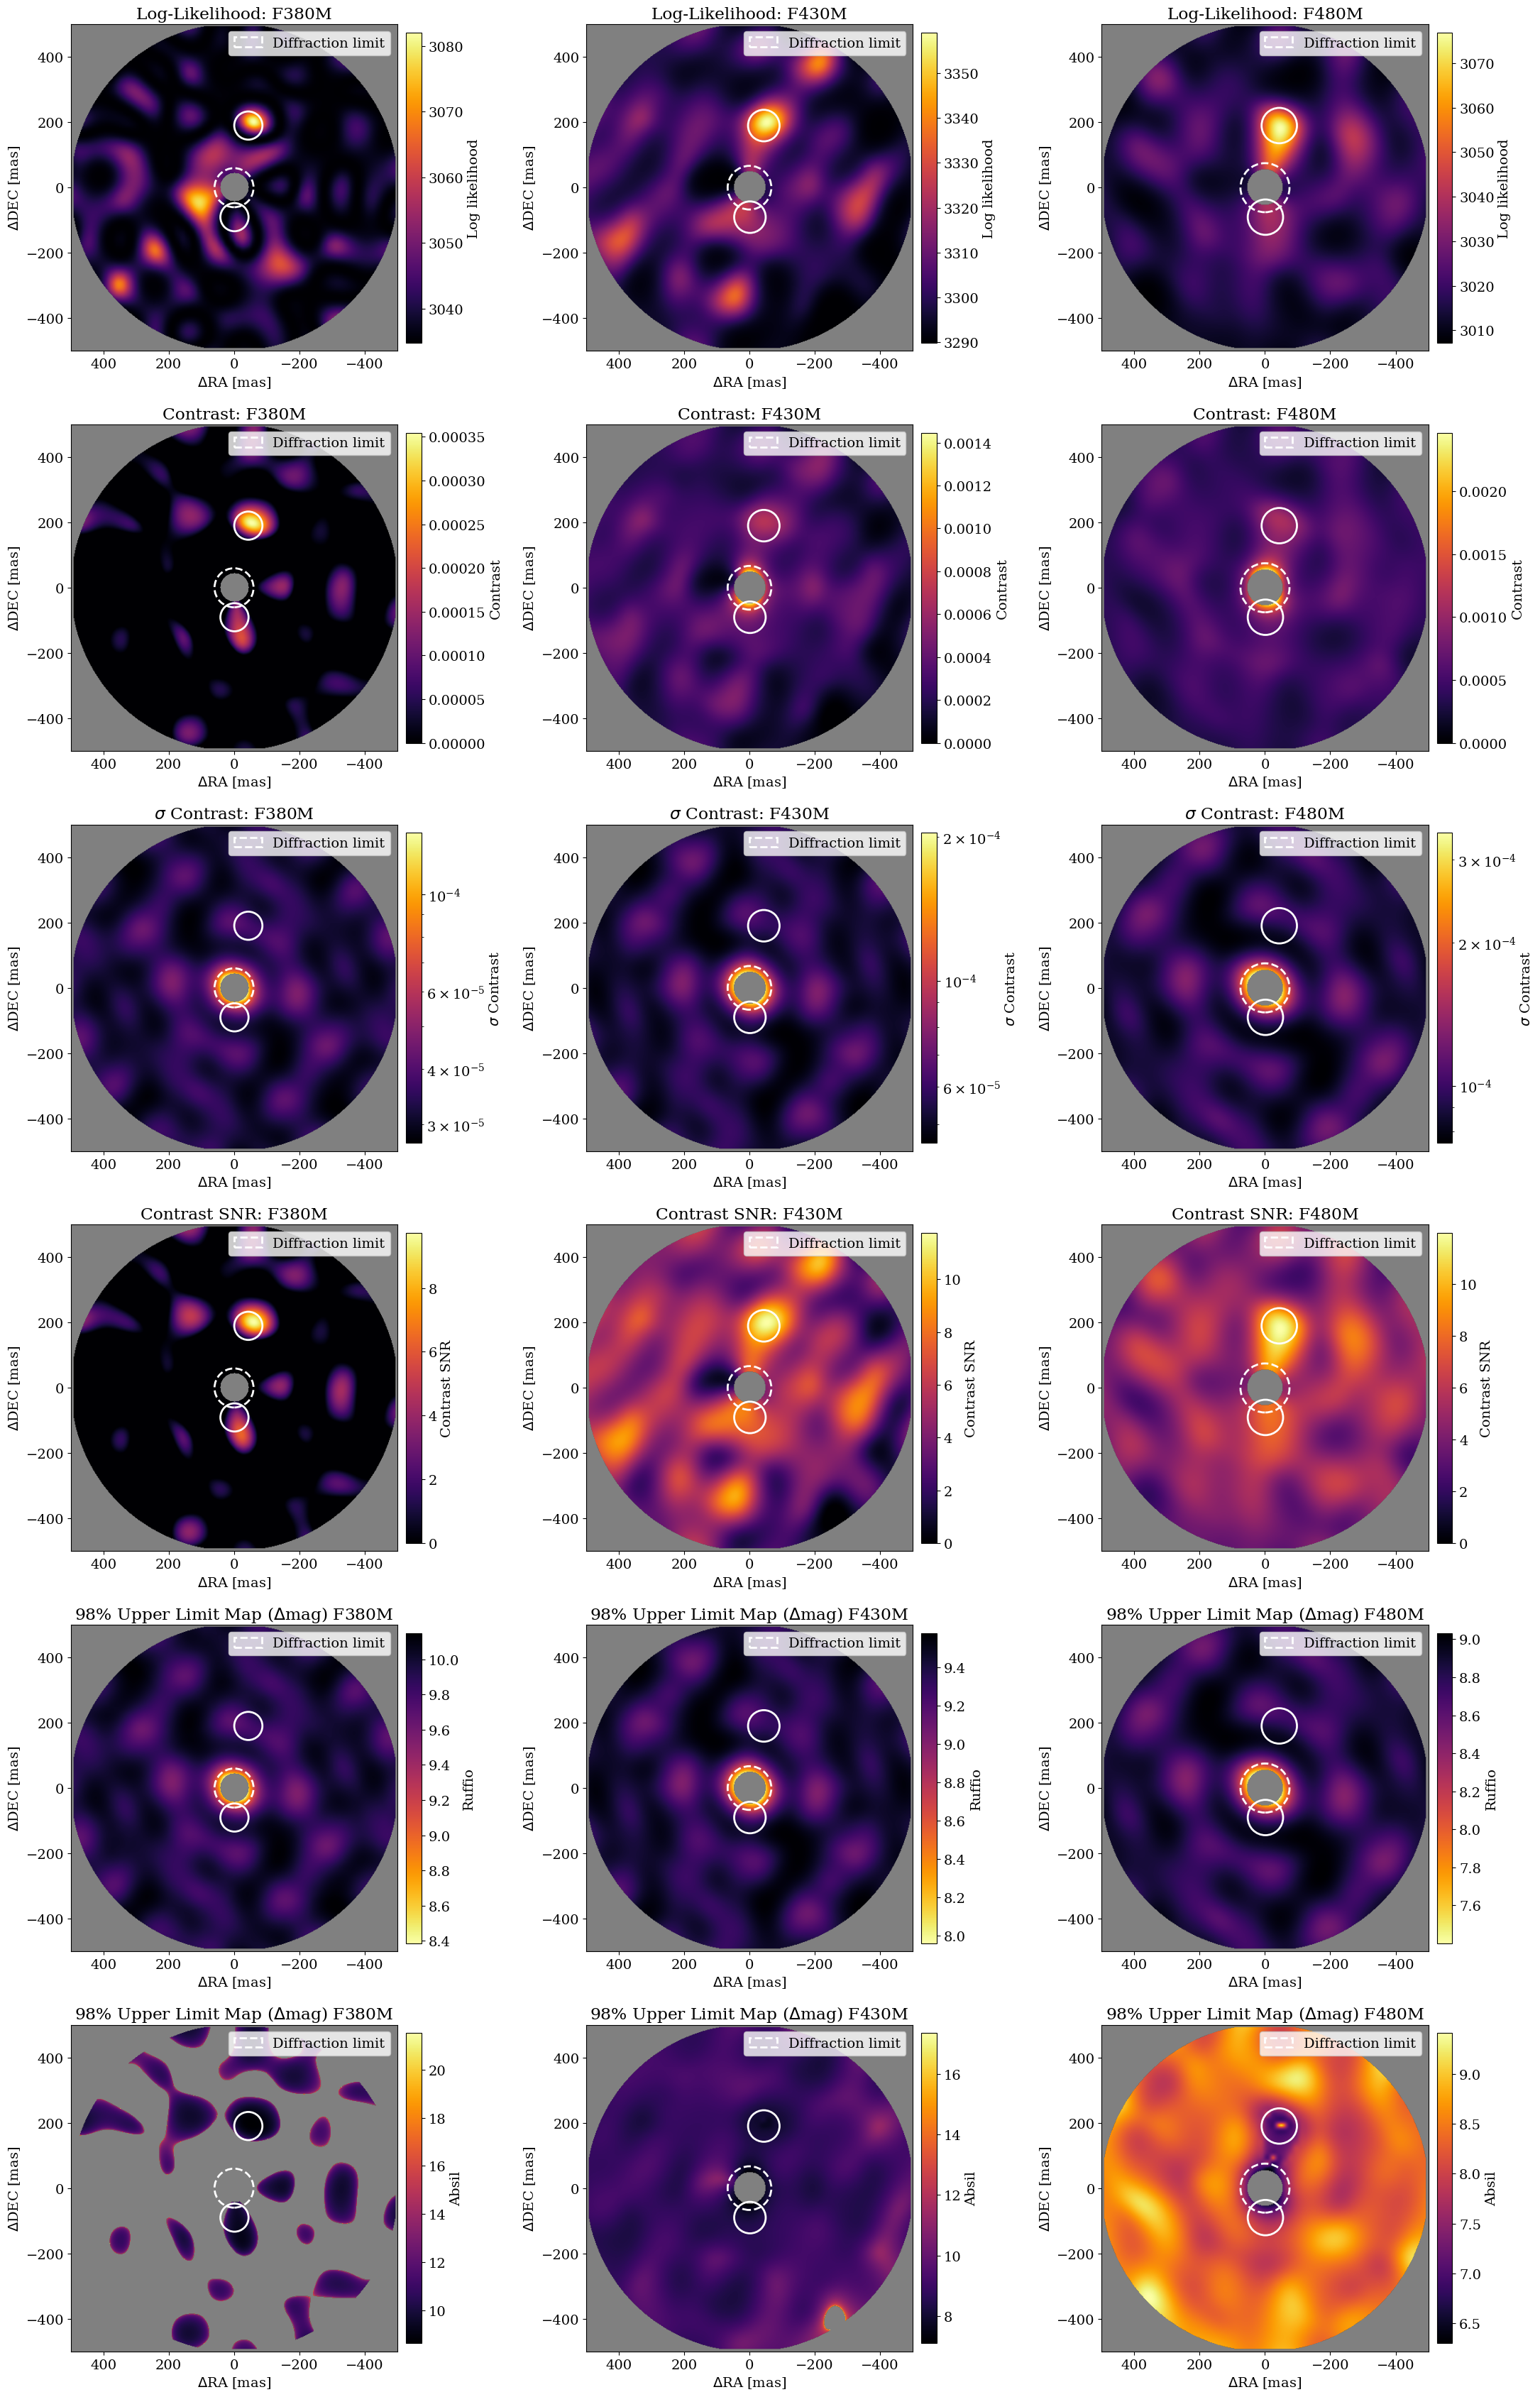

In [4]:
from amigo.optical_models import AMIOptics

optics = AMIOptics()

# Circle making function
make_circle = lambda position, diameter, **kwargs: mpl.patches.Circle(
    position, diameter / 2, color="w", fill=False, linewidth=2, **kwargs
)

plt.figure(figsize=(22, 34))
for i, (filt, output) in enumerate(outputs.items()):
    loglike_im = output["loglike_im"]
    contrast_im = output["contrast_im"]
    sigma_im = output["sigma_im"]
    ruffio_im = output["ruffio_im"]
    limits_im = output["limits_im"]
    min_fov, max_fov = output["fov"]
    extent = output["extent"]
    wavel = output["oi_obj"].wavel

    diff_lim = 1e3 * dlu.rad2arcsec(wavel / optics.diameter)

    def add_to_ax(ax):
        [ax.add_patch(make_circle(binary, 2 * min_fov)) for binary in binaries]
        ax.add_patch(make_circle((0, 0), diff_lim, ls="--", label="Diffraction limit"))
        ax.legend()

    #
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(loglike_im, cmap=inferno, aspect="equal", extent=extent)
    plt.colorbar(shrink=0.95, label="Log likelihood", pad=0.02)
    ax.set(
        title=f"Log-Likelihood: {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    norm = mpl.colors.PowerNorm(1, vmin=0)
    ax = plt.subplot(6, 3, i + 4)
    plt.imshow(contrast_im, cmap=inferno, aspect="equal", extent=extent, norm=norm)
    plt.colorbar(shrink=0.95, label="Contrast", pad=0.02)
    ax.set(
        title=f"Contrast: {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    norm = mpl.colors.LogNorm()
    ax = plt.subplot(6, 3, i + 7)
    plt.imshow(sigma_im, cmap=inferno, aspect="equal", extent=extent, norm=norm)
    plt.colorbar(shrink=0.95, label=r"$\sigma$ Contrast", pad=0.02)
    ax.set(
        title=rf"$\sigma$ Contrast: {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    norm = mpl.colors.PowerNorm(1, vmin=0)
    ax = plt.subplot(6, 3, i + 10)
    plt.imshow(
        contrast_im / sigma_im, cmap=inferno, aspect="equal", extent=extent, norm=norm
    )
    plt.colorbar(shrink=0.95, label="Contrast SNR", pad=0.02)
    ax.set(
        title=f"Contrast SNR: {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    ax = plt.subplot(6, 3, i + 13)
    plt.imshow(
        -2.5 * np.log10(ruffio_im), cmap=inferno_r, aspect="equal", extent=extent
    )
    # plt.imshow(ruffio_im, cmap=inferno_r, aspect="equal", extent=extent)
    plt.colorbar(shrink=0.95, label="Ruffio", pad=0.02)
    ax.set(
        title=f"98% Upper Limit Map ($\\Delta$mag) {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    ax = plt.subplot(6, 3, i + 16)
    plt.imshow(-2.5 * np.log10(limits_im), cmap=inferno, aspect="equal", extent=extent)
    plt.colorbar(shrink=0.95, label="Absil", pad=0.02)
    ax.set(
        title=f"98% Upper Limit Map ($\\Delta$mag) {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

plt.tight_layout()
plt.show()

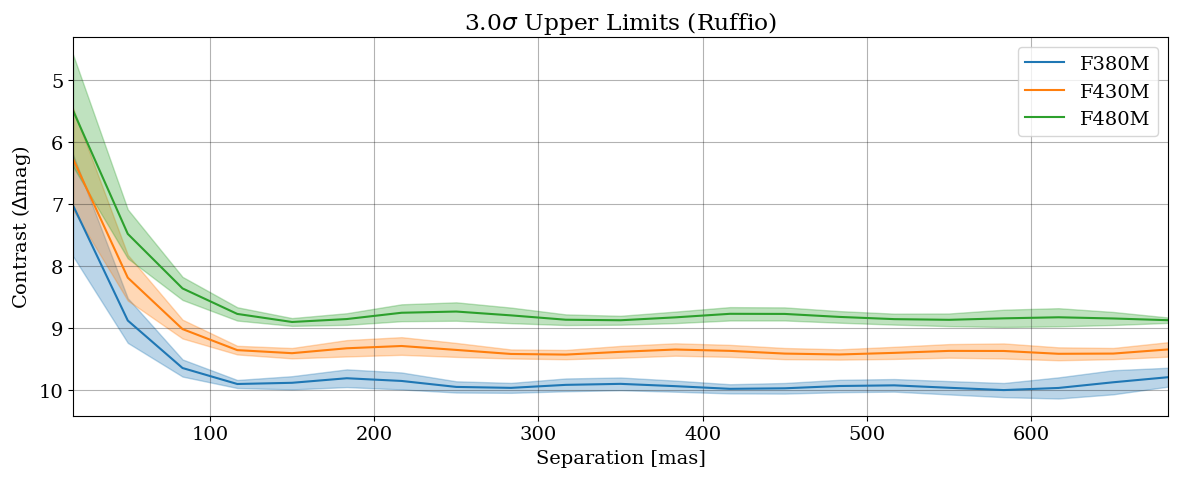

In [5]:
plt.figure(figsize=(12, 5))
for i, (filt, output) in enumerate(outputs.items()):
    rad_width, avg_width, std_width = output["ruffio"]
    n_sigma = output["n_sigma"]

    dx = 1000 / 60
    # plt.title("98% Upper Limits (Ruffio)")
    plt.title(rf"{n_sigma}$\sigma$ Upper Limits (Ruffio)")
    plt.plot(rad_width * dx, avg_width, label=f"{filt}")
    plt.fill_between(
        rad_width * dx,
        avg_width - std_width,
        avg_width + std_width,
        color=f"C{i}",
        alpha=0.3,
    )
    plt.ylabel("Contrast ($\\Delta$mag)")
    plt.xlabel("Separation [mas]")
    plt.gca().invert_yaxis()
    plt.xlim(
        np.nanmin(rad_width * dx + avg_width * 0.0),
        np.nanmax(rad_width * dx + avg_width * 0.0),
    )
    plt.grid(color="black", alpha=0.3)
    plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Run a HMC on the known binaries

In [6]:
import numpyro as npy
import numpyro.distributions as dist


def sampling_fn(oi_objs, multi_model, r=75):

    dras, ddecs = [], []
    for comp, (ra, dec) in companions.items():

        # Define priors
        dra = npy.sample(f"Δ RA {comp}", dist.Uniform(ra - r, ra + r))
        ddec = npy.sample(f"Δ Dec {comp}", dist.Uniform(dec - r, dec + r))
        dras.append(dra)
        ddecs.append(ddec)

        # Track the outputs of the model and the PA/Sep/DMag
        _ = npy.deterministic(f"PA {comp}", dlu.rad2deg(np.arctan2(dec, dra)))
        _ = npy.deterministic(f"Sep {comp}", np.hypot(dra, ddec))
    multi_model = multi_model(dras, ddecs, np.zeros_like(np.array(dras)))

    pred, data, errors = [], [], []
    for filt, oi_data_obj in oi_objs.items():

        fluxes_in = []
        for comp in fluxes.keys():
            log_flux = npy.sample(
                f"log Flux {comp} {filt}", dist.Uniform(*fluxes[comp])
            )
            _ = npy.deterministic(f"Δ Mag {comp} {filt}", -2.5 * log_flux)
            fluxes_in.append(log_flux)
        cvis_pred = oi_data_obj.model(multi_model.set("fluxes", 10**np.array(fluxes_in)))

        pred_data = npy.deterministic(f"pred {filt}", cvis_pred)
        pred.append(pred_data)

        # Error scales
        ones = np.ones(pred_data.size // 2)
        vis_jitter = ones * npy.sample(f"vis_jitter {filt}", dist.Uniform(-1.0, 2.0))
        phi_jitter = ones * npy.sample(f"phi_jitter {filt}", dist.Uniform(-1.0, 2.0))
        jitter = 10 ** np.concatenate([vis_jitter, phi_jitter])

        # Get and jitter the data
        cvis, d_cvis = oi_data_obj.flatten_data()
        data.append(cvis)
        errors.append(d_cvis * jitter)

    #
    data = np.concatenate(data)
    errors = np.concatenate(errors)
    pred_data = np.concatenate(pred)
    model_sampler = dist.Normal(pred_data, errors)
    return npy.sample("Sampler", model_sampler, obs=data)

# First we jointly fit the binaries across all three filters

In [7]:
from amigo.vis_analysis import MultiModelCartesian

oi_data_objs = {}
for i, (filt, oi_data) in enumerate(cal_vis_outputs.items()):
    oi_data_objs[filt] = AmigoOIData(oi_data)

joint_sampler = npy.infer.MCMC(
    npy.infer.NUTS(sampling_fn),
    num_warmup=10000,
    num_samples=10000,
)
joint_sampler.run(jr.PRNGKey(0), oi_data_objs, MultiModelCartesian)

sample: 100%|█████████████████████████████████████████████████████████████| 20000/20000 [03:44<00:00, 88.96it/s, 15 steps of size 2.10e-01. acc. prob=0.92]


# Now we fit uniquely per filter

In [8]:
samplers = {}
for i, (filt, oi_data) in enumerate(cal_vis_outputs.items()):
    sampler = npy.infer.MCMC(
        npy.infer.NUTS(sampling_fn),
        num_warmup=10000,
        num_samples=10000,
    )
    oi_objs = {filt: AmigoOIData(oi_data)}
    sampler.run(jr.PRNGKey(0), oi_objs, MultiModelCartesian, r=100)
    samplers[filt] = sampler

sample: 100%|█████████████████████████████████████████████████████████████| 20000/20000 [01:07<00:00, 296.11it/s, 3 steps of size 4.81e-01. acc. prob=0.86]


In [9]:
joint_sampler.print_summary()
print()

for filt, sampler in samplers.items():
    print(f"{filt} Fit")
    sampler.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
  log Flux b F380M     -3.56      0.12     -3.55     -3.74     -3.37   5118.76      1.00
  log Flux b F430M     -3.23      0.05     -3.22     -3.30     -3.15   7486.03      1.00
  log Flux b F480M     -3.02      0.04     -3.02     -3.07     -2.96   9712.85      1.00
  log Flux c F380M     -4.47      0.33     -4.50     -5.00     -4.01   5371.93      1.00
  log Flux c F430M     -3.51      0.22     -3.51     -3.85     -3.18   2539.94      1.00
  log Flux c F480M     -3.29      0.17     -3.32     -3.55     -3.02   2827.94      1.00
  phi_jitter F380M      0.26      0.02      0.26      0.23      0.29  10166.40      1.00
  phi_jitter F430M      0.01      0.02      0.01     -0.01      0.04  11376.27      1.00
  phi_jitter F480M     -0.16      0.02     -0.16     -0.19     -0.14  10285.88      1.00
  vis_jitter F380M      0.23      0.02      0.23      0.20      0.26  10923.32      1.00
  vis_jitter F430M  

In [ ]:
n_bins = 35
to_amp = lambda x: 100 * (np.exp(x) - 1)
to_phase = lambda x: dlu.rad2deg(x)

vis_analysis = {}
oi_data_objs_clean = {}
for i, (filt, oi_data_obj) in enumerate(oi_data_objs.items()):

    sampler = samplers[filt]
    samples = sampler.get_samples()
    # samples = joint_sampler.get_samples()

    # Get the MCMC error term
    vis_jitter = 10 ** samples[f"vis_jitter {filt}"].mean()
    phi_jitter = 10 ** samples[f"phi_jitter {filt}"].mean()

    # Get the MCMC sample predictions
    posterior_pred = samples[f"pred {filt}"]
    posterior_mean = np.mean(posterior_pred, axis=0)
    posterior_std = np.std(posterior_pred, axis=0)
    n = len(oi_data_obj.vis)

    vis_analysis[filt] = {
        "vis_pred": to_amp(posterior_mean[:n]),
        "vis_std": to_amp(posterior_std[:n]),
        "vis": to_amp(oi_data_obj.vis),
        "d_vis": to_amp(oi_data_obj.d_vis),
        "phi_pred": to_phase(posterior_mean[n:]),
        "phi_std": to_phase(posterior_std[n:]),
        "phi": to_phase(oi_data_obj.phi),
        "d_phi": to_phase(oi_data_obj.d_phi),
        "vis_jitter": vis_jitter,
        "phi_jitter": phi_jitter,
    }


    # TODO: Do we want to be applying the vis jitters here????
    # Subtract off the MLE, for later re-analysis
    vis = oi_data_obj.vis - posterior_mean[:n]
    d_vis = np.hypot(oi_data_obj.d_vis, posterior_std[:n])
    phi = oi_data_obj.phi - posterior_mean[n:]
    d_phi = np.hypot(oi_data_obj.d_phi, posterior_std[n:])

    oi_data_objs_clean[filt] = oi_data_obj.set(
        ["vis", "d_vis", "phi", "d_phi"], [vis, d_vis, phi, d_phi]
    )

# Let have a look how well our samples fit our data

RMS residual / median data error
F380M:
  Vis: 1.1077 - 0.2130 - 0.1923
  Phi: 1.0204 - 0.1192 - 0.1168
F430M:
  Vis: 0.9907 - 0.2142 - 0.2162
  Phi: 1.0454 - 0.1226 - 0.1173
F480M:
  Vis: 1.0481 - 0.3492 - 0.3331
  Phi: 1.0193 - 0.1499 - 0.1471


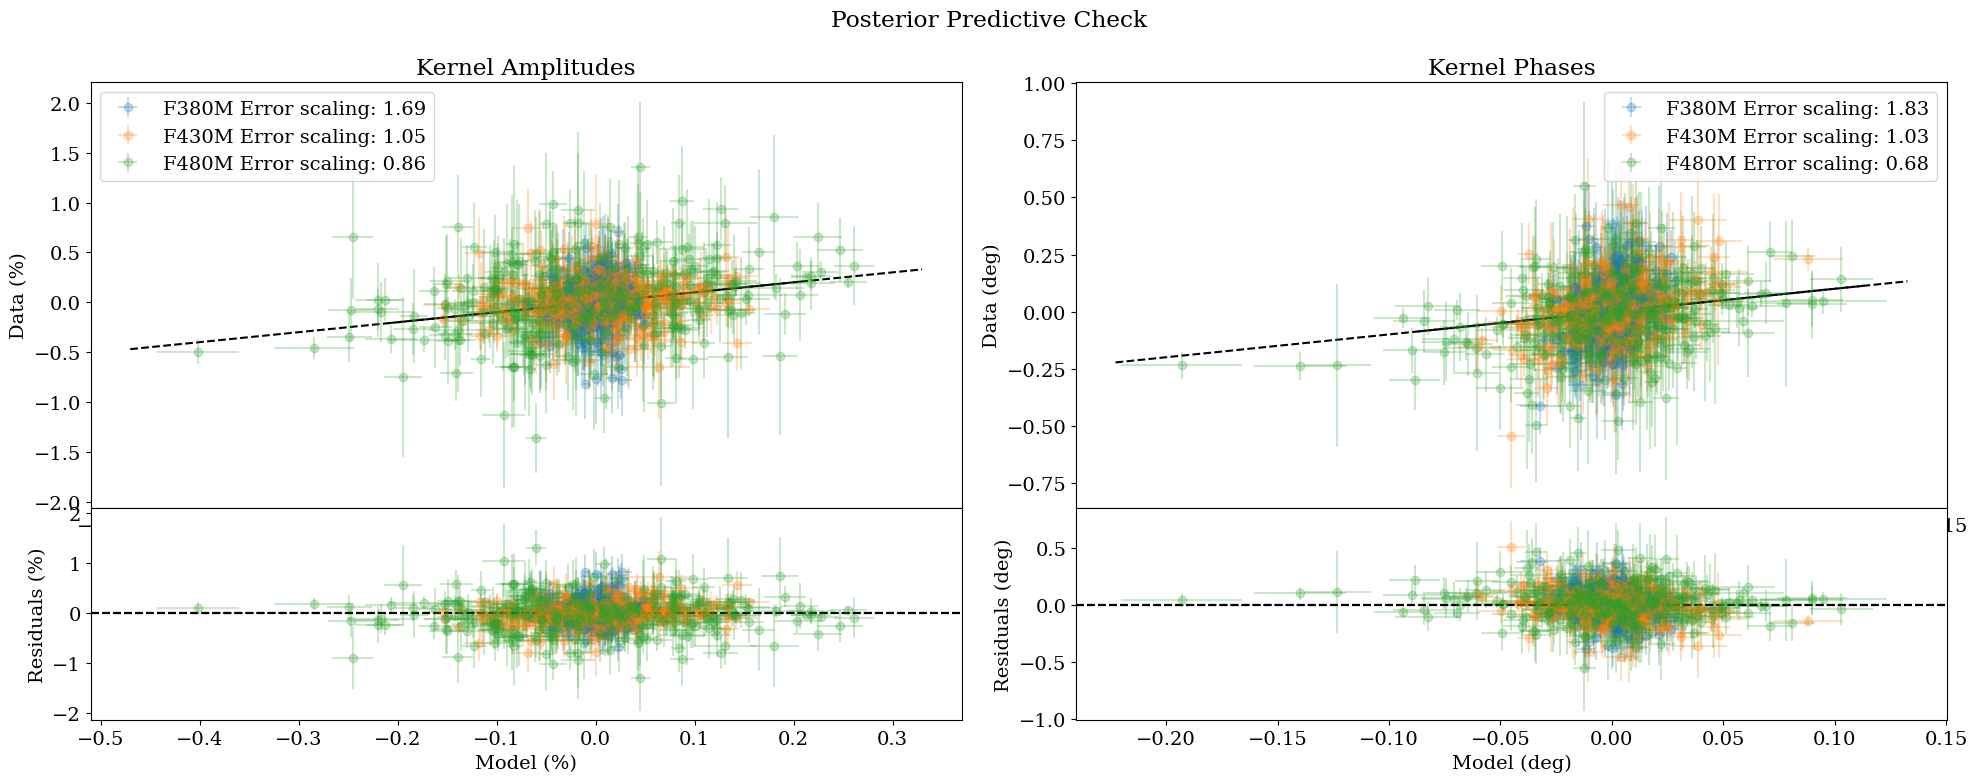

In [11]:
from matplotlib.gridspec import GridSpec
from amigo.stats import chi2, bin_data

# Create a 2x2 grid with shared x-axes in columns
fig = plt.figure(figsize=(20, 8))
fig.suptitle("Posterior Predictive Check")

gs = GridSpec(2, 2, height_ratios=[2, 1], hspace=0.0)  # less vertical spacing

# Main plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Residual plots
res1 = fig.add_subplot(gs[1, 0], sharex=ax1)
res2 = fig.add_subplot(gs[1, 1], sharex=ax2)

print("RMS residual / median data error")

for i, filt in enumerate(vis_analysis.keys()):

    vis_pred = vis_analysis[filt]["vis_pred"]
    vis_std = vis_analysis[filt]["vis_std"]
    vis = vis_analysis[filt]["vis"]
    d_vis = vis_analysis[filt]["d_vis"]
    phi_pred = vis_analysis[filt]["phi_pred"]
    phi_std = vis_analysis[filt]["phi_std"]
    phi = vis_analysis[filt]["phi"]
    d_phi = vis_analysis[filt]["d_phi"]
    vis_jitter = vis_analysis[filt]["vis_jitter"]
    phi_jitter = vis_analysis[filt]["phi_jitter"]

    d_vis *= vis_jitter
    d_phi *= phi_jitter

    # Reduce Chi squared
    ddof = len(d_vis) - 3
    vis_chi2 = chi2(vis, vis_pred, d_vis, ddof)
    phi_chi2 = chi2(phi, phi_pred, d_phi, ddof)

    # RMS and Median Error
    rms = lambda x: np.sqrt(np.mean(x**2))
    med_err = lambda x: np.median(np.abs(x))
    vis_precision = rms(vis_pred - vis) / med_err(d_vis)
    phi_precision = rms(phi_pred - phi) / med_err(d_phi)
    print(f"{filt}:")
    print(f"  Vis: {vis_precision:.4f} - {rms(vis_pred - vis):.4f} - {med_err(d_vis):.4f}")
    print(f"  Phi: {phi_precision:.4f} - {rms(phi_pred - phi):.4f} - {med_err(d_phi):.4f}")

    # y = x plotting lines
    vis_med = np.nanmedian(vis_std)
    vis_min, vis_max = np.nanmin(vis_pred), np.nanmax(vis_pred)
    vis_121 = np.linspace(vis_min - 5 * vis_med, vis_max + 5 * vis_med, 100)

    phi_med = np.nanmedian(phi_std)
    phi_min, phi_max = np.nanmin(phi_pred), np.nanmax(phi_pred)
    phi_121 = np.linspace(phi_min - 5 * phi_med, phi_max + 5 * phi_med, 100)

    errplt = lambda ax, *args, **kwargs: ax.errorbar(
        *args, fmt="o", alpha=0.25, color=f"C{i}", **kwargs
    )

    ax1.plot(vis_121, vis_121, "k--")
    errplt(ax1, vis_pred, vis, yerr=d_vis, xerr=vis_std)
    errplt(res1, vis_pred, vis_pred - vis, yerr=d_vis, xerr=vis_std)
    errplt(ax1, [], [], xerr=[], yerr=[], label=rf"{filt} Error scaling: {vis_jitter:.2f}")

    ax2.plot(phi_121, phi_121, "k--")
    errplt(ax2, phi_pred, phi, yerr=d_phi, xerr=phi_std)
    errplt(res2, phi_pred, phi_pred - phi, yerr=d_phi, xerr=phi_std)
    errplt(ax2, [], [], xerr=[], yerr=[], label=rf"{filt} Error scaling: {phi_jitter:.2f}")

    ax1.set(title="Kernel Amplitudes", ylabel="Data (%)", xlabel="Model (%)")
    ax2.set(title="Kernel Phases",  ylabel="Data (deg)", xlabel="Model (deg)")

    res1.set(ylabel="Residuals (%)", xlabel="Model (%)")
    res2.set(ylabel="Residuals (deg)", xlabel="Model (deg)")
    ax1.legend()
    ax2.legend()

    res1.axhline(0, color="k", ls="--")
    res2.axhline(0, color="k", ls="--")

plt.tight_layout()
plt.show()

RMS residual / median data error
F380M:
  Vis: 0.99 - 0.04 - 0.04
  Phi: 1.48 - 0.04 - 0.03
F430M:
  Vis: 1.19 - 0.06 - 0.05
  Phi: 1.33 - 0.04 - 0.03
F480M:
  Vis: 1.26 - 0.10 - 0.08
  Phi: 1.20 - 0.04 - 0.03


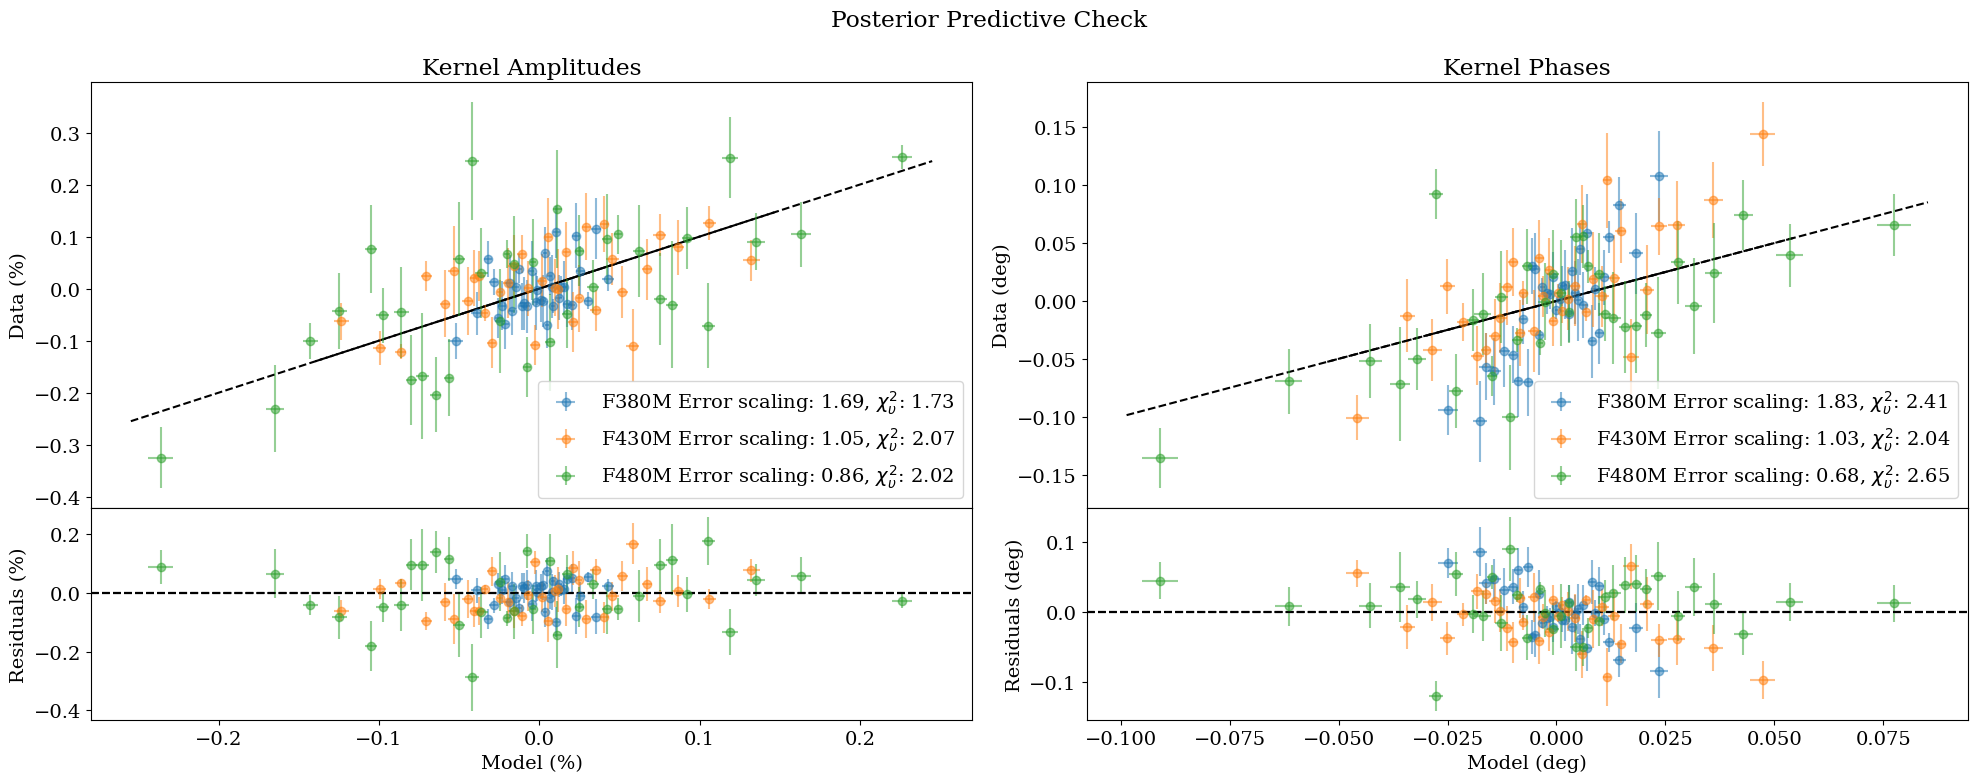

In [ ]:
# Create a 2x2 grid with shared x-axes in columns
fig = plt.figure(figsize=(20, 8))
fig.suptitle("Posterior Predictive Check")

gs = GridSpec(2, 2, height_ratios=[2, 1], hspace=0.0)  # less vertical spacing

# Main plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Residual plots
res1 = fig.add_subplot(gs[1, 0], sharex=ax1)
res2 = fig.add_subplot(gs[1, 1], sharex=ax2)

print("RMS residual / median data error")

for i, filt in enumerate(vis_analysis.keys()):

    vis_pred = vis_analysis[filt]["vis_pred"]
    vis_std = vis_analysis[filt]["vis_std"]
    vis = vis_analysis[filt]["vis"]
    d_vis = vis_analysis[filt]["d_vis"]
    phi_pred = vis_analysis[filt]["phi_pred"]
    phi_std = vis_analysis[filt]["phi_std"]
    phi = vis_analysis[filt]["phi"]
    d_phi = vis_analysis[filt]["d_phi"]
    vis_jitter = vis_analysis[filt]["vis_jitter"]
    phi_jitter = vis_analysis[filt]["phi_jitter"]

    # Apply the error jitter terms before binning
    d_vis *= vis_jitter
    d_phi *= phi_jitter

    # Bin the visibilities
    bin_inds = np.array_split(np.argsort(vis_pred), n_bins)
    vis_pred, vis_std = bin_data(vis_pred, vis_std, bin_inds)
    vis, d_vis = bin_data(vis, d_vis, bin_inds)

    # Bin the phases
    bin_inds = np.array_split(np.argsort(phi_pred), n_bins)
    phi_pred, phi_std = bin_data(phi_pred, phi_std, bin_inds)
    phi, d_phi = bin_data(phi, d_phi, bin_inds)

    # Reduce Chi squared
    ddof = len(d_vis) - 3
    vis_chi2 = chi2(vis, vis_pred, d_vis, ddof)
    phi_chi2 = chi2(phi, phi_pred, d_phi, ddof)

    # RMS and Median Error
    rms = lambda x: np.sqrt(np.mean(x**2))
    med_err = lambda x: np.median(np.abs(x))
    vis_precision = rms(vis_pred - vis) / med_err(d_vis)
    phi_precision = rms(phi_pred - phi) / med_err(d_phi)
    print(f"{filt}:")
    print(f"  Vis: {vis_precision:.2f} - {rms(vis_pred - vis):.2f} - {med_err(d_vis):.2f}")
    print(f"  Phi: {phi_precision:.2f} - {rms(phi_pred - phi):.2f} - {med_err(d_phi):.2f}")

    # y = x plotting lines
    vis_med = np.nanmedian(vis_std)
    vis_min, vis_max = np.nanmin(vis_pred), np.nanmax(vis_pred)
    vis_121 = np.linspace(vis_min - 5 * vis_med, vis_max + 5 * vis_med, 100)

    phi_med = np.nanmedian(phi_std)
    phi_min, phi_max = np.nanmin(phi_pred), np.nanmax(phi_pred)
    phi_121 = np.linspace(phi_min - 5 * phi_med, phi_max + 5 * phi_med, 100)

    errplt = lambda ax, *args, **kwargs: ax.errorbar(
        *args, fmt="o", alpha=0.5, color=f"C{i}", **kwargs
    )

    ax1.plot(vis_121, vis_121, "k--")
    errplt(ax1, vis_pred, vis, yerr=d_vis, xerr=vis_std)
    errplt(res1, vis_pred, vis_pred - vis, yerr=d_vis, xerr=vis_std)
    errplt(ax1, [], [], xerr=[], yerr=[], label=rf"{filt} Error scaling: {vis_jitter:.2f}, $\chi^2_\upsilon$: {vis_chi2:.2f}")

    ax2.plot(phi_121, phi_121, "k--")
    errplt(ax2, phi_pred, phi, yerr=d_phi, xerr=phi_std)
    errplt(res2, phi_pred, phi_pred - phi, yerr=d_phi, xerr=phi_std)
    errplt(ax2, [], [], xerr=[], yerr=[], label=rf"{filt} Error scaling: {phi_jitter:.2f}, $\chi^2_\upsilon$: {phi_chi2:.2f}")

    ax1.set(title="Kernel Amplitudes", ylabel="Data (%)", xlabel="Model (%)")
    ax2.set(title="Kernel Phases",  ylabel="Data (deg)", xlabel="Model (deg)")

    res1.set(ylabel="Residuals (%)", xlabel="Model (%)")
    res2.set(ylabel="Residuals (deg)", xlabel="Model (deg)")
    ax1.legend()
    ax2.legend()

    res1.axhline(0, color="k", ls="--")
    res2.axhline(0, color="k", ls="--")

plt.tight_layout()
plt.show()

# Examine the fit to the first companion

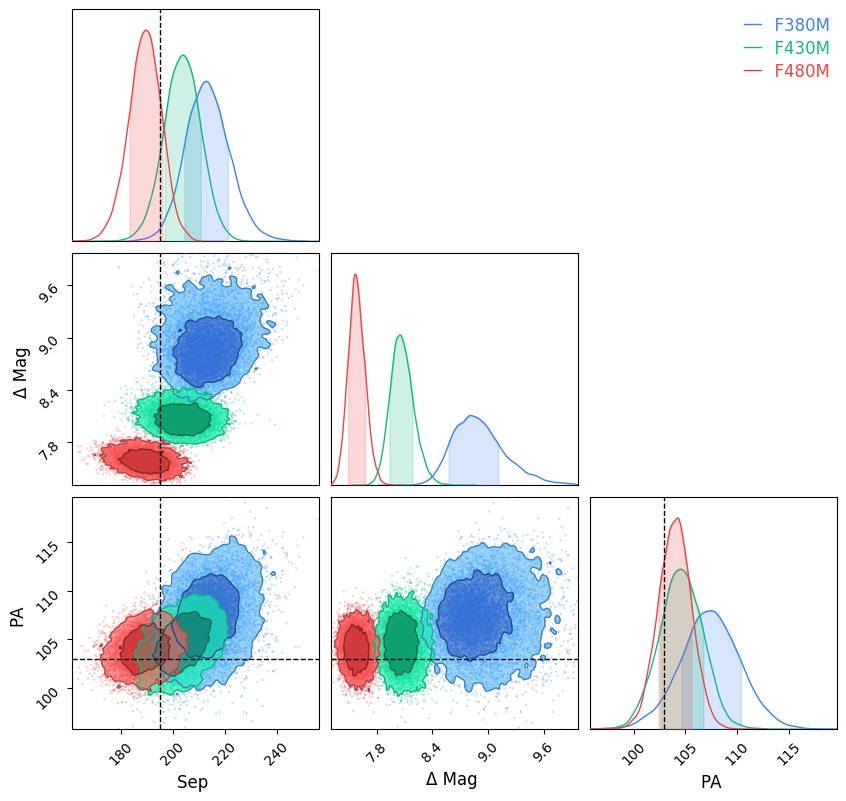

In [13]:
from chainconsumer import ChainConsumer, Chain, Truth
import pandas as pd

n_sigma = 3
true_ra, true_dec = binaries[0]

c = ChainConsumer()
truths = {
    "Δ Dec": true_dec,
    "Δ RA": true_ra,
    "Sep": np.hypot(true_ra, true_dec),
    "PA": dlu.rad2deg(np.arctan2(true_dec, true_ra)),
}


c.add_truth(Truth(location=truths))

# Plot the joint fit data or the individual fits
joint = False

# Plot polar or cartesian coordinates
polar = True

for filt in vis_analysis.keys():
    if polar:
        params = ["Sep b", f"Δ Mag b {filt}", "PA b"]
        keys = ["Sep", "Δ Mag", "PA"]
    else:
        params = ["Δ RA b", "Δ Dec b", f"Δ Mag b {filt}"]
        keys = ["Δ RA", "Δ Dec", "Δ Mag"]

    if joint:
        results = joint_sampler.get_samples()
    else:
        sampler = samplers[filt]
        results = sampler.get_samples()
    results = {key: results[param] for key, param in zip(keys, params)}
    cc_df = pd.DataFrame.from_dict(results)

    c.add_chain(
        Chain(
            samples=cc_df,
            name=filt,
            plot_cloud=True,
            marker_style="*",
            marker_size=100,
        )
    )

c.plotter.plot()
plt.show()

# Examine the fit to the second companion

Note its signal is much harder to detect, so we plot the _joint_ fit

Parameter Δ Mag in chain F380M (joint) is not constrained


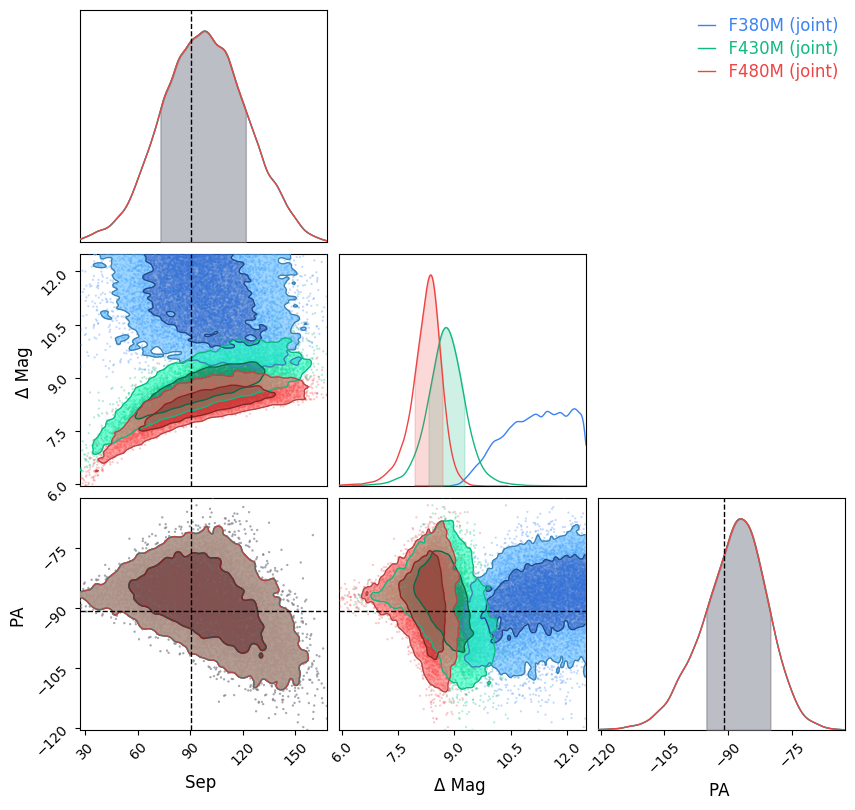

In [14]:
from chainconsumer import ChainConsumer, Chain, Truth
import pandas as pd


true_ra, true_dec = binaries[1]
truths = {
    "Δ Dec": true_dec,
    "Δ RA": true_ra,
    "Sep": np.hypot(true_ra, true_dec),
    "PA": dlu.rad2deg(np.arctan2(true_dec, true_ra)),
}

c = ChainConsumer()
c.add_truth(Truth(location=truths))

# Plot the joint fit data or the individual fits
joint = True

# Plot polar or cartesian coordinates
polar = True

for filt in vis_analysis.keys():
    if polar:
        params = ["Sep c", f"Δ Mag c {filt}", "PA c"]
        keys = ["Sep", "Δ Mag", "PA"]
    else:
        params = ["Δ RA c", "Δ Dec c", f"Δ Mag c {filt}"]
        keys = ["Δ RA", "Δ Dec", "Δ Mag"]

    if joint:
        results = joint_sampler.get_samples()
    else:
        sampler = samplers[filt]
        results = sampler.get_samples()
    results = {key: results[param] for key, param in zip(keys, params)}
    cc_df = pd.DataFrame.from_dict(results)

    c.add_chain(
        Chain(
            samples=cc_df,
            name=f"{filt} (joint)",
            plot_cloud=True,
            marker_style="*",
            marker_size=100,
        )
    )

c.plotter.plot()
plt.show()

# Re-run the analysis with the known binaries subtracted

In [15]:
import dLux.utils as dlu
from amigo.misc import tqdm

# Calculate the log-likelihoods
outputs = {}
for filt, oi_obj in tqdm(oi_data_objs_clean.items()):
    outputs[filt] = analyse_vis(
        oi_obj,
        size=500,  # mas
        n_pts=500,  # number of points in the final grid
        n_grid=60,  # number of initial grid points
        n_batch=1,  # number of batches to calculate the likelihood
        min_flux=-6,  # minimum log flux range
        tol=1e-8,  # tolerance for the optimizer (linear OR log space)
        max_steps=512,  # maximum number of steps for the optimizer
        n_sigma=3.0,  # number of sigma for the upper limits
        log=False,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

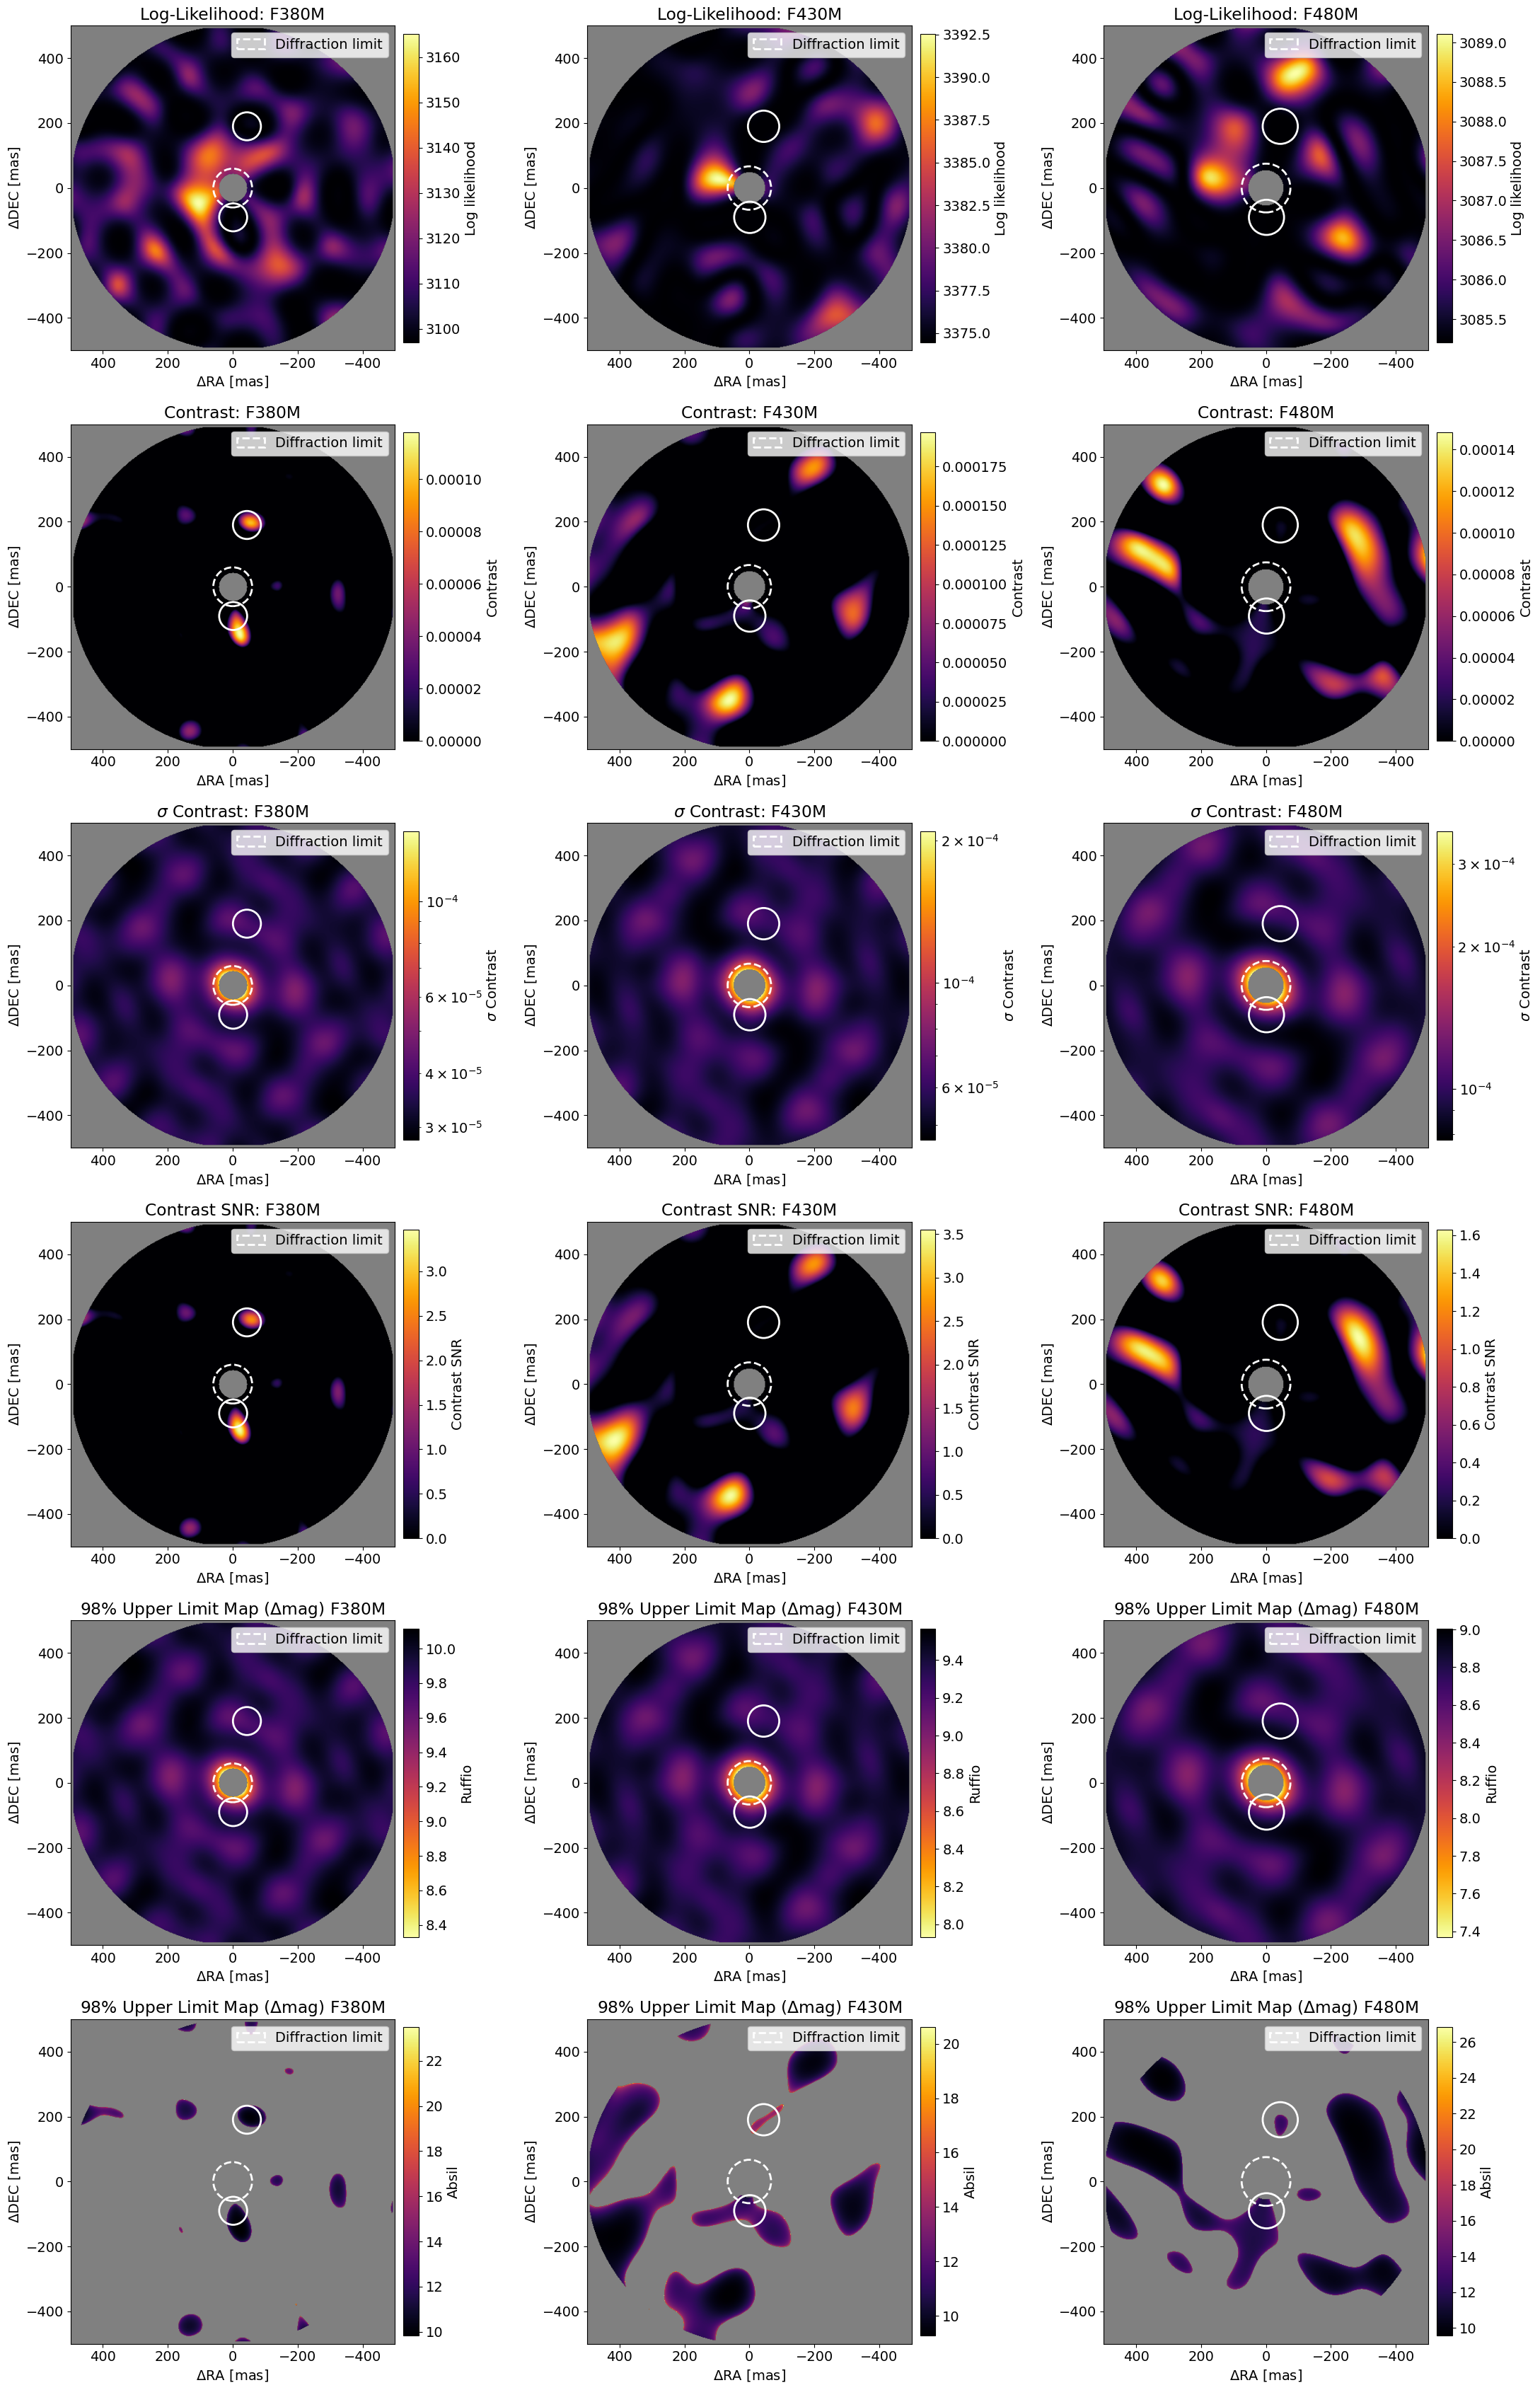

In [16]:
# Circle making function
make_circle = lambda position, diameter, **kwargs: mpl.patches.Circle(
    position, diameter / 2, color="w", fill=False, linewidth=2, **kwargs
)

plt.figure(figsize=(22, 34))
for i, (filt, output) in enumerate(outputs.items()):
    loglike_im = output["loglike_im"]
    contrast_im = output["contrast_im"]
    sigma_im = output["sigma_im"]
    ruffio_im = output["ruffio_im"]
    limits_im = output["limits_im"]
    min_fov, max_fov = output["fov"]
    extent = output["extent"]
    wavel = output["oi_obj"].wavel

    diff_lim = 1e3 * dlu.rad2arcsec(wavel / optics.diameter)

    def add_to_ax(ax):
        [ax.add_patch(make_circle(binary, 2 * min_fov)) for binary in binaries]
        ax.add_patch(make_circle((0, 0), diff_lim, ls="--", label="Diffraction limit"))
        ax.legend()

    #
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(loglike_im, cmap=inferno, aspect="equal", extent=extent)
    plt.colorbar(shrink=0.95, label="Log likelihood", pad=0.02)
    ax.set(
        title=f"Log-Likelihood: {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    norm = mpl.colors.PowerNorm(1, vmin=0)
    ax = plt.subplot(6, 3, i + 4)
    plt.imshow(contrast_im, cmap=inferno, aspect="equal", extent=extent, norm=norm)
    plt.colorbar(shrink=0.95, label="Contrast", pad=0.02)
    ax.set(
        title=f"Contrast: {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    norm = mpl.colors.LogNorm()
    ax = plt.subplot(6, 3, i + 7)
    plt.imshow(sigma_im, cmap=inferno, aspect="equal", extent=extent, norm=norm)
    plt.colorbar(shrink=0.95, label=r"$\sigma$ Contrast", pad=0.02)
    ax.set(
        title=rf"$\sigma$ Contrast: {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    norm = mpl.colors.PowerNorm(1, vmin=0)
    ax = plt.subplot(6, 3, i + 10)
    plt.imshow(contrast_im / sigma_im, cmap=inferno, aspect="equal", extent=extent, norm=norm)
    plt.colorbar(shrink=0.95, label="Contrast SNR", pad=0.02)
    ax.set(
        title=f"Contrast SNR: {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    ax = plt.subplot(6, 3, i + 13)
    plt.imshow(
        -2.5 * np.log10(ruffio_im), cmap=inferno_r, aspect="equal", extent=extent
    )
    # plt.imshow(ruffio_im, cmap=inferno_r, aspect="equal", extent=extent)
    plt.colorbar(shrink=0.95, label="Ruffio", pad=0.02)
    ax.set(
        title=f"98% Upper Limit Map ($\\Delta$mag) {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

    ax = plt.subplot(6, 3, i + 16)
    plt.imshow(-2.5 * np.log10(limits_im), cmap=inferno, aspect="equal", extent=extent)
    plt.colorbar(shrink=0.95, label="Absil", pad=0.02)
    ax.set(
        title=f"98% Upper Limit Map ($\\Delta$mag) {filt}",
        xlabel="$\\Delta$RA [mas]",
        ylabel="$\\Delta$DEC [mas]",
    )
    add_to_ax(ax)

plt.tight_layout()
plt.show()

# Look at the upper limits of the data with the best-fit binaries subtracted

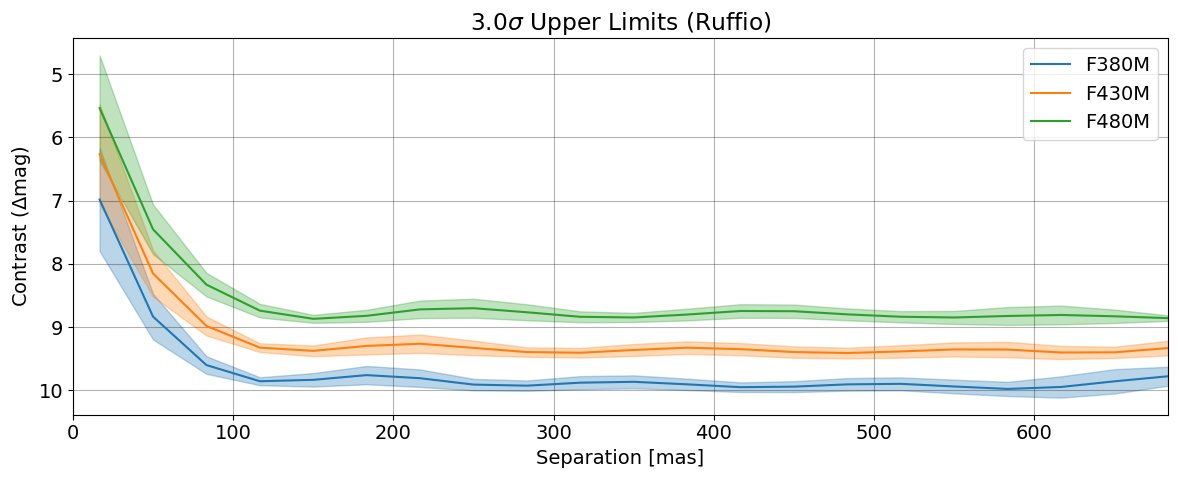

In [17]:
plt.figure(figsize=(12, 5))
for i, (filt, output) in enumerate(outputs.items()):
    rad_width, avg_width, std_width = output["ruffio"]
    n_sigma = output["n_sigma"]

    dx = 1000 / 60
    # plt.title("98% Upper Limits (Ruffio)")
    plt.title(rf"{n_sigma}$\sigma$ Upper Limits (Ruffio)")
    plt.plot(rad_width * dx, avg_width, label=f"{filt}")
    plt.fill_between(
        rad_width * dx,
        avg_width - std_width,
        avg_width + std_width,
        color=f"C{i}",
        alpha=0.3,
    )
    plt.ylabel("Contrast ($\\Delta$mag)")
    plt.xlabel("Separation [mas]")
    plt.gca().invert_yaxis()
    # plt.xlim(
    #     np.nanmin(rad_width * dx + avg_width * 0.0),
    #     np.nanmax(rad_width * dx + avg_width * 0.0),
    # )
    plt.xlim(
        0.,
        np.nanmax(rad_width * dx + avg_width * 0.0),
    )
    plt.grid(color="black", alpha=0.3)
    plt.legend(loc="best")
plt.tight_layout()
plt.show()